In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import h5py
import numpy as np

h5_path = "/content/drive/MyDrive/Codigos_Fallos/Carpeta_Dataset/dataset_sync.h5"

X_vib, X_acoustic, X_temp, y = [], [], [], []

with h5py.File(h5_path, "r") as f:
    for cond in f.keys():
        g = f[cond]
        try:
            # Vibración
            v1 = g["vibration"]["accel_1"]["signal_sync"][:].astype(np.float32)
            v2 = g["vibration"]["accel_2"]["signal_sync"][:].astype(np.float32)
            if len(v1) == 0 or len(v2) == 0:
                continue
            min_len_vib = min(len(v1), len(v2))
            vib = np.stack([v1[:min_len_vib], v2[:min_len_vib]], axis=0)

            # Acústico
            if "acoustic" in g:
                a = g["acoustic"]["signal_sync"][:].astype(np.float32)
                if len(a) == 0:
                    a = np.zeros(min_len_vib, dtype=np.float32)
            else:
                a = np.zeros(min_len_vib, dtype=np.float32)

            # Temperatura
            if "temperature" in g["external"]:
                tmp = g["external"]["temperature"]["signal_sync"][:].astype(np.float32)
                if len(tmp) == 0:
                    tmp = np.zeros(min_len_vib, dtype=np.float32)
            else:
                tmp = np.zeros(min_len_vib, dtype=np.float32)

            # Ajustar longitudes
            min_len_group = min(min_len_vib, len(a), len(tmp))
            vib = vib[:, :min_len_group]
            a   = a[:min_len_group]
            tmp = tmp[:min_len_group]

            # Guardar
            X_vib.append(vib)
            X_acoustic.append(a)
            X_temp.append(tmp)
            y.append(cond)

        except Exception as e:
            print(f"Saltando {cond} por error: {e}")

# Recorte global
min_len_all = min(
    min(x.shape[1] for x in X_vib),
    min(len(a) for a in X_acoustic),
    min(len(t) for t in X_temp)
)

X_vib      = np.array([x[:, :min_len_all] for x in X_vib])
X_acoustic = np.array([a[:min_len_all] for a in X_acoustic])
X_temp     = np.array([t[:min_len_all] for t in X_temp])
y          = np.array(y)

print("Shapes después de recorte global:")
print("Vib:", X_vib.shape)
print("Acoustic:", X_acoustic.shape)
print("Temp:", X_temp.shape)
print("y:", y.shape)


Shapes después de recorte global:
Vib: (45, 2, 1536000)
Acoustic: (45, 1536000)
Temp: (45, 1536000)
y: (45,)


In [3]:
# Mapping clases
unique_labels = sorted(set(y))
label_map = {name: idx for idx, name in enumerate(unique_labels)}
y_idx = np.array([label_map[name] for name in y])

num_classes = len(unique_labels)
print("Número de clases:", num_classes)

# Expandir dimensiones
X_acoustic = X_acoustic[:, np.newaxis, :]   # (N,1,L)
X_temp     = X_temp[:, np.newaxis, :]       # (N,1,L)

# Concatenar vib (2) + ac (1) = (3,L)
X_base = np.concatenate([X_vib, X_acoustic], axis=1)

# Normalización
mean_base = X_base.mean(axis=(0,2), keepdims=True)
std_base  = X_base.std(axis=(0,2), keepdims=True) + 1e-8
X_base = (X_base - mean_base) / std_base

mean_temp = X_temp.mean(axis=(0,2), keepdims=True)
std_temp  = X_temp.std(axis=(0,2), keepdims=True) + 1e-8
X_temp = (X_temp - mean_temp) / std_temp

print("X_base:", X_base.shape, "X_temp:", X_temp.shape)


Número de clases: 45
X_base: (45, 3, 1536000) X_temp: (45, 1, 1536000)


In [4]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split

class MotorDataset(Dataset):
    def __init__(self, X_base, X_temp, y, window_size=2048, step=2048):
        self.X_base = X_base
        self.X_temp = X_temp
        self.y = y
        self.window_size = window_size
        self.step = step
        self.indices = []

        for i in range(len(X_base)):
            n = X_base[i].shape[1]
            for start in range(0, n - window_size + 1, step):
                end = start + window_size
                self.indices.append((i, start, end))

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        sample_idx, start, end = self.indices[idx]
        x_base = self.X_base[sample_idx][:, start:end]
        x_temp = self.X_temp[sample_idx][:, start:end]
        label = self.y[sample_idx]
        return (
            torch.tensor(x_base, dtype=torch.float32),
            torch.tensor(x_temp, dtype=torch.float32),
            torch.tensor(label, dtype=torch.long),
        )

dataset = MotorDataset(X_base, X_temp, y_idx, window_size=2048, step=2048)

train_size = int(0.8 * len(dataset))
val_size   = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)

print("Ventanas totales:", len(dataset))
print("Train:", len(train_dataset), "Val:", len(val_dataset))


Ventanas totales: 33750
Train: 27000 Val: 6750


In [5]:
import torch.nn as nn
import torch.nn.functional as F

class FuzzyLayerExtended(nn.Module):
    def __init__(self, n_sets=3, out_dim=64):
        super(FuzzyLayerExtended, self).__init__()
        self.n_sets = n_sets
        self.centers = nn.Parameter(torch.linspace(-1, 1, n_sets))
        self.sigmas  = nn.Parameter(torch.ones(n_sets) * 0.5)

        # Bloque conv para procesar las membresías
        self.conv = nn.Sequential(
            nn.Conv1d(n_sets, 16, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(16)
        )
        self.fc = nn.Linear(16*16, out_dim)

    def membership(self, x, c, s):
        return torch.exp(-0.5 * ((x - c) / s) ** 2)

    def forward(self, x):
        B, _, L = x.shape
        sets = []
        for j in range(self.n_sets):
            mu = self.membership(x.squeeze(1), self.centers[j], self.sigmas[j])  # (B,L)
            sets.append(mu.unsqueeze(1))
        fuzzy_out = torch.cat(sets, dim=1)      # (B, n_sets, L)
        fuzzy_feat = self.conv(fuzzy_out)       # (B,16,16)
        return self.fc(fuzzy_feat.flatten(1))   # (B, out_dim)

class CNN_FuzzyTempInput_Ext(nn.Module):
    def __init__(self, num_classes):
        super(CNN_FuzzyTempInput_Ext, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(3, 16, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(64)
        )
        self.fuzzy_temp = FuzzyLayerExtended(n_sets=3, out_dim=64)
        self.fc = nn.Sequential(
            nn.Linear(32*64 + 64, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x_base, x_temp):
        feat = self.conv(x_base).flatten(1)      # vib+acoustic
        temp_feat = self.fuzzy_temp(x_temp)      # temperatura fuzzy extendida
        feat_all = torch.cat([feat, temp_feat], dim=1)
        return self.fc(feat_all)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_FuzzyTempInput_Ext(num_classes).to(device)
print(model)


CNN_FuzzyTempInput_Ext(
  (conv): Sequential(
    (0): Conv1d(3, 16, kernel_size=(7,), stride=(2,), padding=(3,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(16, 32, kernel_size=(5,), stride=(2,), padding=(2,))
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): AdaptiveAvgPool1d(output_size=64)
  )
  (fuzzy_temp): FuzzyLayerExtended(
    (conv): Sequential(
      (0): Conv1d(3, 16, kernel_size=(5,), stride=(2,), padding=(2,))
      (1): ReLU()
      (2): AdaptiveAvgPool1d(output_size=16)
    )
    (fc): Linear(in_features=256, out_features=64, bias=True)
  )
  (fc): Sequential(
    (0): Linear(in_features=2112, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=45, bias=True)
  )
)


In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 200
patience = 15
best_val_acc = 0.0
epochs_no_improve = 0
best_model_path = "best_model_fuzzy_temp_input_ext.pth"

for epoch in range(num_epochs):
    model.train()
    train_loss, train_correct, total = 0, 0, 0
    for x_base, x_temp, y_batch in train_loader:
        x_base, x_temp, y_batch = x_base.to(device), x_temp.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_base, x_temp)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x_base.size(0)
        preds = outputs.argmax(dim=1)
        train_correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

    train_acc = train_correct / total
    train_loss /= total

    # ---- Validación ----
    model.eval()
    val_loss, val_correct, total_val = 0, 0, 0
    with torch.no_grad():
        for x_base, x_temp, y_batch in val_loader:
            x_base, x_temp, y_batch = x_base.to(device), x_temp.to(device), y_batch.to(device)
            outputs = model(x_base, x_temp)
            loss = criterion(outputs, y_batch)

            val_loss += loss.item() * x_base.size(0)
            preds = outputs.argmax(dim=1)
            val_correct += (preds == y_batch).sum().item()
            total_val += y_batch.size(0)

    val_acc = val_correct / total_val
    val_loss /= total_val

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ Mejor modelo guardado en epoch {epoch+1} con val_acc={val_acc:.4f}")
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print("⏹ Early stopping activado")
        break

print(f"Entrenamiento finalizado. Mejor val_acc={best_val_acc:.4f}, modelo en {best_model_path}")


Epoch [1/200] Train Loss: 1.4223, Acc: 0.4840 Val Loss: 0.7316, Acc: 0.6890
✅ Mejor modelo guardado en epoch 1 con val_acc=0.6890
Epoch [2/200] Train Loss: 1.0246, Acc: 0.5846 Val Loss: 0.6779, Acc: 0.7065
✅ Mejor modelo guardado en epoch 2 con val_acc=0.7065
Epoch [3/200] Train Loss: 0.9181, Acc: 0.6246 Val Loss: 0.5172, Acc: 0.7822
✅ Mejor modelo guardado en epoch 3 con val_acc=0.7822
Epoch [4/200] Train Loss: 0.7965, Acc: 0.6734 Val Loss: 0.4805, Acc: 0.8022
✅ Mejor modelo guardado en epoch 4 con val_acc=0.8022
Epoch [5/200] Train Loss: 0.7307, Acc: 0.6954 Val Loss: 0.3888, Acc: 0.8784
✅ Mejor modelo guardado en epoch 5 con val_acc=0.8784
Epoch [6/200] Train Loss: 0.7035, Acc: 0.7079 Val Loss: 0.3910, Acc: 0.8625
Epoch [7/200] Train Loss: 0.6750, Acc: 0.7118 Val Loss: 0.4137, Acc: 0.8341
Epoch [8/200] Train Loss: 0.6547, Acc: 0.7216 Val Loss: 0.3821, Acc: 0.8489
Epoch [9/200] Train Loss: 0.6349, Acc: 0.7315 Val Loss: 0.3638, Acc: 0.8505
Epoch [10/200] Train Loss: 0.6464, Acc: 0.7234

Cohen's Kappa (global): 0.9253


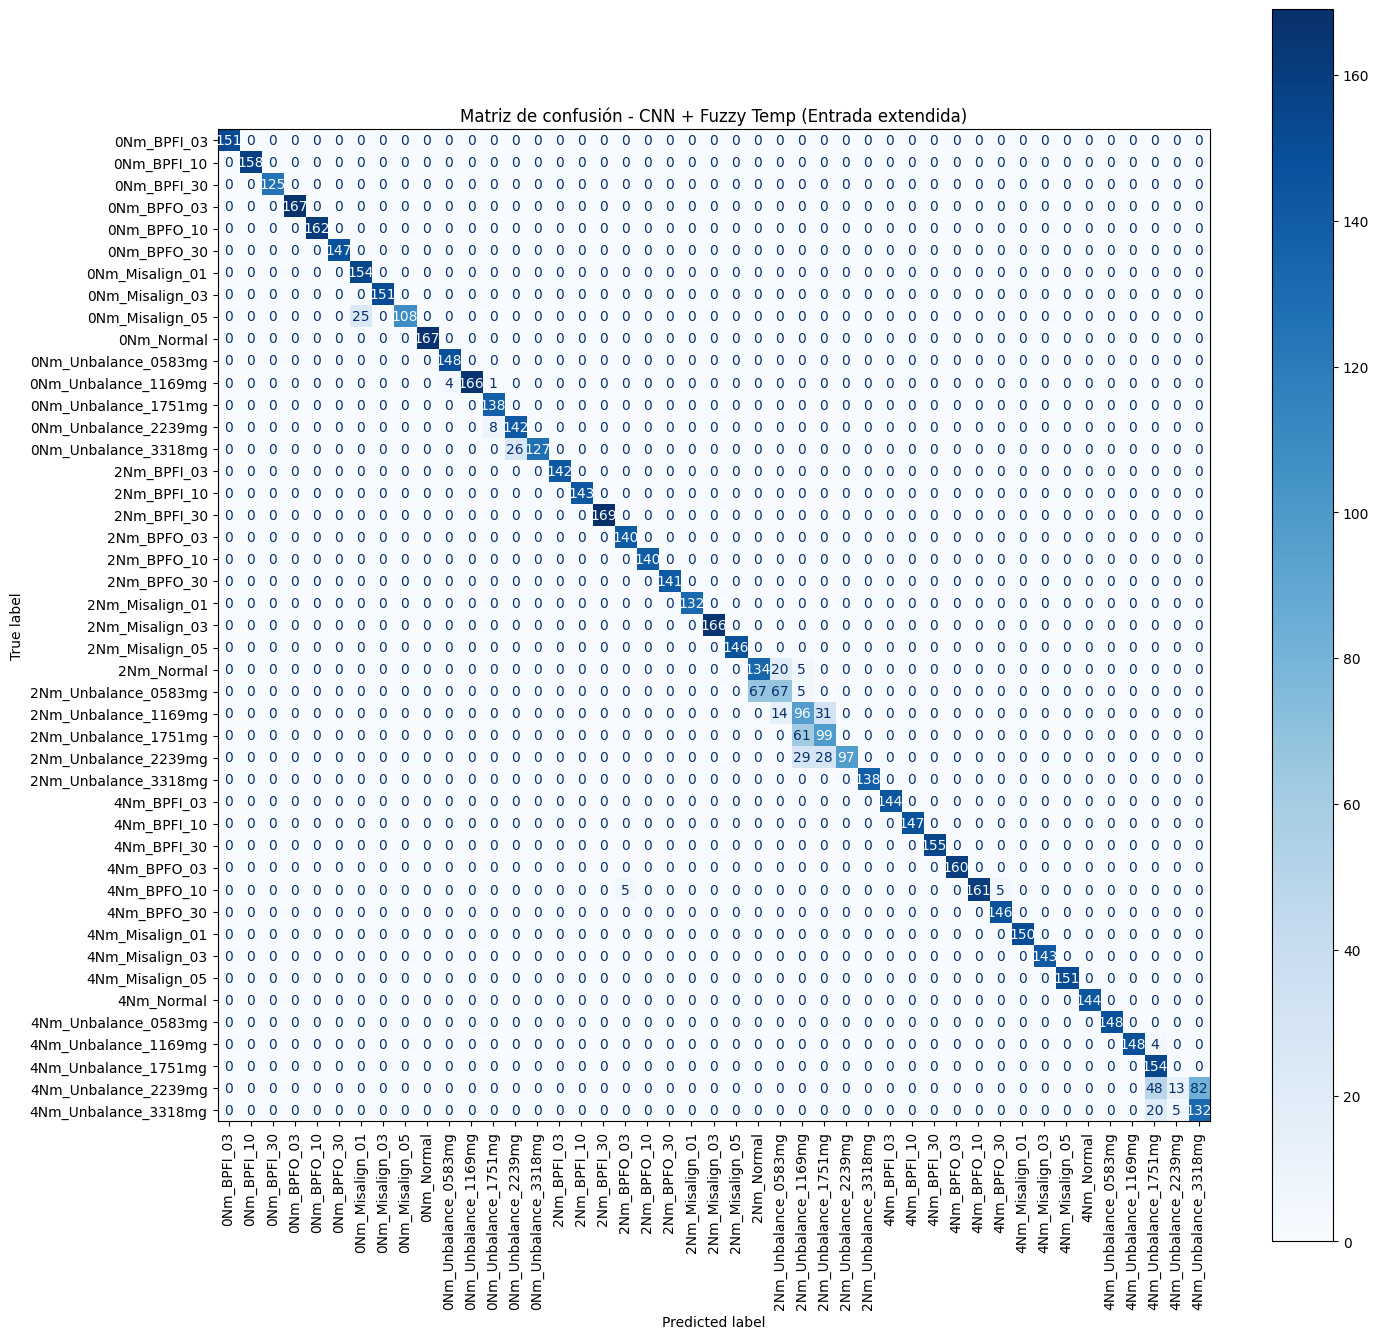

In [7]:
from sklearn.metrics import cohen_kappa_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# =====================
# Cargar mejor modelo guardado
# =====================
best_model = CNN_FuzzyTempInput_Ext(num_classes).to(device)
best_model.load_state_dict(torch.load("best_model_fuzzy_temp_input_ext.pth", map_location=device))
best_model.eval()

all_labels, all_preds = [], []

# =====================
# Evaluación en set de validación
# =====================
with torch.no_grad():
    for x_base, x_temp, y_batch in val_loader:
        x_base, x_temp, y_batch = x_base.to(device), x_temp.to(device), y_batch.to(device)

        outputs = best_model(x_base, x_temp)
        preds = outputs.argmax(dim=1)

        all_labels.extend(y_batch.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

# =====================
# Cohen's Kappa (global)
# =====================
kappa = cohen_kappa_score(all_labels, all_preds)
print(f"Cohen's Kappa (global): {kappa:.4f}")

# =====================
# Matriz de confusión
# =====================
cm = confusion_matrix(all_labels, all_preds, labels=np.arange(num_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)

fig, ax = plt.subplots(figsize=(16, 16))
disp.plot(ax=ax, cmap="Blues", colorbar=True, xticks_rotation=90)
plt.title("Matriz de confusión - CNN + Fuzzy Temp (Entrada extendida)")
plt.show()
